### Final Project: Is Night Light Measurement a Good Proxy for Economic Activities?

Group Number: 24

First Name: Xiaoman 

Last Name: Luo

Student ID: 998682239


#### Introduction
Economics and other fields of applied science have highly regarded the analysis of satellite data. Satellite data provides honest information of global activities, since its data is not collected by national data agencies and thus will not be limited by data capacity, agency efficiency, or biasedness from other sources.  

In particular, economists widely use night light information from satellite images as a proxy for economic activities. This is because economists believe that more night light will be generated due to the increase in economic activities. In addition, night light images have advantages of high area coverage, high frequency, high resolution, and low marginal cost to obtain, compared to measures of economic activities such as gross domestic product (GDP), consumption, etc. In this project, I want to "test" if this is a valid belief. Specifically, I want to explore whether night light measurement is a good approximation of economic activities. In this project, I use GDP as the variable for economic activities.

In [1]:
import os
import numpy as np
import pandas as pd
import plotnine as p9
import plotly.plotly as py
import plotly.graph_objs as go 
import geopandas as gpd
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype
from pandas.plotting import scatter_matrix
from ipywidgets import widgets, interactive
from ipywidgets import *

#### Data
The data used in this project comes from 4 sources. I will introduce the first 3 sources in this section, and leave the introduction of the fourth source in the section for machine learning. 

###### Data Source 1
The first one is from the paper $\scriptsize \textit{Night-time lights: A global, long term look at links to socio-economic trends}$ by by Proville et al. (2017). The authors provide an "area lit" metric for night light measurement of each country and nation-state from 1992 to 2013. They use a threshold digital number (DN) of 31 within a band range up to 63, which rules out pixels of smaller, temporary lighting while keeping the majority of stable lit areas. The pixel counts are subsequently converted into their equivalent areal coverages in square kilometers. The dataset provided in this paper also include varibles such as GDP and other proxy variables for GDP. Each row represents observation for a country in one year. 

Note: For the year 2002, satellite data does note include regions to the north of latitude 58 ̊N. Thus, in the original dataset, regions in this area are omitted from the night light variable in 2002. However, inorder to plot these areas on the map, I added these regions back the data set with country code (Code), country names (Region), and year (Year), and mark other variable values as missing (NaN). 

In [2]:
# Source 1: Nightlight Paper 
ori_data = pd.read_excel('nightlight.xlsx')
print('The shape of the nightlight data is',ori_data.shape)
list(ori_data)

The shape of the nightlight data is (5405, 12)


['Code',
 'Region',
 'Year',
 'Area Lit (Log, km2)',
 'Electricity Consumption (Log, Billion kWh)',
 'CO2 Emissions (Log, metric tonnes)',
 'Gross Domestic Product (Log, Billion (Nominal) Current US$)',
 'Population (Log)',
 'N2O Emissions (Log, kt of CO2 equivalent)',
 'CH4 Emissions (Log, kt of CO2 equivalent)',
 'HFC, PFC and SF6 Emissions (Log, kt of CO2 equivalent)',
 'Poverty Headcount Ratio (at national poverty lines)']

In [3]:
# Change col names 
ori_data.columns = ['Code','Region','Year','Area Lit','Electricity Consumption',
                    'CO2 Emissions','GDP','Population','N2O Emissions',
                    'CH4 Emissions','Fluoride Emissions','Poverty Headcount Ratio']

In [4]:
# Check year range
ori_data['Year'].unique()

array([2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003,
       2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992])

In [5]:
# Value counts of Year
ori_data['Year'].value_counts()

2011    246
2007    246
1996    246
2000    246
2004    246
2008    246
2012    246
1993    246
1997    246
2001    246
2005    246
2009    246
2013    246
1994    246
1998    246
2006    246
2010    246
1995    246
1999    246
2003    246
1992    246
2002    239
Name: Year, dtype: int64

In [6]:
# Find missing countries in 2002
temp1 = ori_data.loc[ori_data['Year'] == 2001]['Code'].unique()
temp2 = ori_data.loc[ori_data['Year'] == 2002]['Code'].unique()
diff02 = list(set(temp1) - set(temp2))
diff02

['FIN', 'GRL', 'RUS', 'SWE', 'EST', 'NOR', 'ALA']

In [7]:
# Generate a new dataframe of missing countries
miss=ori_data[ori_data['Code'].isin(diff02)].loc[ori_data['Year']==2001][['Code','Region']]
miss['Year'] = [2002] *7
miss_varnames=[x for x in ori_data.columns if x not in ['Code', 'Region', 'Year']]
for var in miss_varnames:
    miss[var] = np.nan
miss

,Code,Region,Year,Area Lit,Electricity Consumption,CO2 Emissions,GDP,Population,N2O Emissions,CH4 Emissions,Fluoride Emissions,Poverty Headcount Ratio
2949,ALA,Aland Islands,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014,EST,Estonia,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3016,FIN,Finland,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3035,GRL,Greenland,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3111,NOR,Norway,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3133,RUS,Russia,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3153,SWE,Sweden,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
ori_data.shape

(5405, 12)

In [9]:
# Add the "miss" dataframe to the original data
data = ori_data.append(miss)
# Count by Year after adding missing countries
data['Year'].value_counts()

2011    246
2007    246
1996    246
2000    246
2004    246
2008    246
2012    246
1993    246
1997    246
2001    246
2005    246
2009    246
2013    246
1994    246
1998    246
2002    246
2006    246
2010    246
1995    246
1999    246
2003    246
1992    246
Name: Year, dtype: int64

###### Data Source 2
The second source of data is the shapefile for administrative boundaries of countries and nation-states from the Thematic Mapping World Borders Dataset: http://thematicmapping.org/downloads/world_borders.php. Each row represents each country.

This shapefile data is merged to the previous night light data.

In [10]:
# Source 2: World admin map shapefile
shapefile = 'TM_WORLD_BORDERS-0.3.shp'
gdf = gpd.read_file(shapefile)[['ISO3', 'geometry']].to_crs('+proj=robin')

In [11]:
# Before merging, check that countries are coded consistently in each data set 
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
lst1 = data['Code'].unique()
lst2 = gdf['ISO3'].unique()

# Check the two datasets will be merged by the same country code.
check = len(intersection(lst1, lst2)) == len(lst1)
print('The two datasets will be merged by the same country code: {}.'.format(check))

The two datasets will be merged by the same country code: True.


In [12]:
# Merge night light data with shapefile data
nl_map_merged = gdf.merge(data, left_on='ISO3', right_on='Code')
print('The shape of merged nightlight-map data is',nl_map_merged.shape)
nl_map_merged.head()

The shape of merged nightlight-map data is (5412, 14)


,ISO3,geometry,Code,Region,Year,Area Lit,Electricity Consumption,CO2 Emissions,GDP,Population,N2O Emissions,CH4 Emissions,Fluoride Emissions,Poverty Headcount Ratio
0,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2013,4.437774,-1.205774,13.169974,0.182811,11.407398,NaN,NaN,NaN,NaN
1,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2012,4.508274,-1.227753,13.169974,0.186241,11.397167,NaN,NaN,2.283402,NaN
2,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2011,4.654189,-1.243754,13.148772,0.122145,11.386818,NaN,NaN,2.283402,NaN
3,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2010,4.711373,-1.256741,13.169974,0.127107,11.376338,NaN,NaN,2.283402,NaN
4,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2009,4.279858,-1.250226,13.141603,0.187649,11.365585,NaN,NaN,2.209373,NaN


###### Data Source 3
The third source of data is from Kaggle, where each row records the income group and continent information of each country. This Kaggle data is obtained from the World Development Indicator from the World Bank. I did not directly obtain it from the World Bank because this data provided by Kaggle is a relatively older version that contains OECD and nonOECD information in country income group, which is important for my later analysis, but the current version of World Development Indicator from the World Bank no longer has this OECD information in the variable for income group. 

Note that in this data set, variable $\scriptsize \textit{CountryCode}$ corresponds to variable $\scriptsize \textit{Code}$ in the previous dataset, and variable $\scriptsize \textit{LongName}$ corresponds to variable $\scriptsize \textit{Region}$ in the previous dataset. However, there are difference in the definition of countries as well as in the coding of country names in these two data sets. 

After adjusting country code based on countries' full names, there are still 40 different countries in this data set than the previous one.  

In [13]:
# Source 3: Kaggle
countrydf = pd.read_csv('Country.csv')[['CountryCode', 'LongName', 'Region', 'IncomeGroup']]
c_names = countrydf.columns.tolist()
c_names[c_names.index('Region')] = 'Continent'
countrydf.columns = c_names
countrydf.head()

,CountryCode,LongName,Continent,IncomeGroup
0,AFG,Islamic State of Afghanistan,South Asia,Low income
1,ALB,Republic of Albania,Europe & Central Asia,Upper middle income
2,DZA,People's Democratic Republic of Algeria,Middle East & North Africa,Upper middle income
3,ASM,American Samoa,East Asia & Pacific,Upper middle income
4,ADO,Principality of Andorra,Europe & Central Asia,High income: nonOECD


In [14]:
# Find the number of inconsistently coded countries
lst3 = nl_map_merged['Code'].unique()
lst4 = countrydf['CountryCode'].unique()
len(lst3) - len(intersection(lst3, lst4))

43

In [15]:
# Among them, find those with the same country names 
lst5 = nl_map_merged['Region'].unique()
lst6 = countrydf['LongName'].unique()
its = intersection(lst5, lst6)
nl_map_merged[nl_map_merged['Region'].isin(its)].loc[nl_map_merged['Year']==2001][['Code','Region']]

,Code,Region
12,ATG,Antigua and Barbuda
144,ASM,American Samoa
232,BRB,Barbados
320,BLZ,Belize
342,BIH,Bosnia and Herzegovina
430,SLB,Solomon Islands
496,BRN,Brunei Darussalam
518,CAN,Canada
606,COD,Democratic Republic of the Congo
738,CYM,Cayman Islands


In [16]:
# Add a new column 'Code' to code these countries the same way as the nightlight-map data.
countrydf['Code'] =  countrydf['CountryCode'].copy()

# Could use a for-loop here, but this is more readable
countrydf.loc[countrydf['LongName'] == 'Democratic Republic of the Congo', 'Code'] = 'COD'
countrydf.loc[countrydf['LongName'] == 'Isle of Man', 'Code'] = 'IMN'
countrydf.loc[countrydf['LongName'] == 'Romania', 'Code'] = 'ROU'

In [17]:
# Merge data
all_merged = nl_map_merged.merge(countrydf, left_on='Code', right_on = 'Code', how = 'left')
print('The shape of merged nightlight-map-kaggle data is',all_merged.shape)
all_merged.head()

The shape of merged nightlight-map-kaggle data is (5412, 18)


,ISO3,geometry,Code,Region,Year,Area Lit,Electricity Consumption,CO2 Emissions,GDP,Population,N2O Emissions,CH4 Emissions,Fluoride Emissions,Poverty Headcount Ratio,CountryCode,LongName,Continent,IncomeGroup
0,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2013,4.437774,-1.205774,13.169974,0.182811,11.407398,NaN,NaN,NaN,NaN,ATG,Antigua and Barbuda,Latin America & Caribbean,High income: nonOECD
1,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2012,4.508274,-1.227753,13.169974,0.186241,11.397167,NaN,NaN,2.283402,NaN,ATG,Antigua and Barbuda,Latin America & Caribbean,High income: nonOECD
2,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2011,4.654189,-1.243754,13.148772,0.122145,11.386818,NaN,NaN,2.283402,NaN,ATG,Antigua and Barbuda,Latin America & Caribbean,High income: nonOECD
3,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2010,4.711373,-1.256741,13.169974,0.127107,11.376338,NaN,NaN,2.283402,NaN,ATG,Antigua and Barbuda,Latin America & Caribbean,High income: nonOECD
4,ATG,(POLYGON ((-5752464.709728298 1820794.66038189...,ATG,Antigua and Barbuda,2009,4.279858,-1.250226,13.141603,0.187649,11.365585,NaN,NaN,2.209373,NaN,ATG,Antigua and Barbuda,Latin America & Caribbean,High income: nonOECD


In [18]:
# Remove geometry to make all_merged smaller
all_merged = all_merged.drop(columns = 'geometry')

In [19]:
# Save all_merged to csv
all_merged.to_csv('all_merged.csv')

In [20]:
# Check column data types
all_merged.dtypes

ISO3                        object
Code                        object
Region                      object
Year                         int64
Area Lit                   float64
Electricity Consumption    float64
CO2 Emissions              float64
GDP                        float64
Population                 float64
N2O Emissions              float64
CH4 Emissions              float64
Fluoride Emissions         float64
Poverty Headcount Ratio    float64
CountryCode                 object
LongName                    object
Continent                   object
IncomeGroup                 object
dtype: object

#### What is the Spatial-Temporal Trend of Night light and GDP?
In this section, I want to explore the spatial-temporal trend of night light. To begin with, I draw an interactive map that depicts the global distribution of night light of a specific year. The 'yr' button can be moved to select any year of interest as long as it is within the 1992-2013 time range. The darker color represents higher night light intensity. The color legend is set to be the same for all years, so different maps are comparable in intensity levels based on their colors.

Moving the button from the left-most (year 1992) to the right-most (year 2013), the color is relatively stable at the beginning, but becomes darker at a faster speed as time goes by. This is especially in Africa, Middle East, and Central Asia. 

In [21]:
# In this part, I will define a function of maps for night light during 1992 - 2013 

nl = all_merged.copy()[['Code', 'Region','Year','Area Lit']]

# First, set the range of color scale to be the same for all years 
vmin = np.floor(all_merged['Area Lit'].describe()['min'])
vmax = np.ceil(all_merged['Area Lit'].describe()['max'])

value = 'Area Lit'
colors = 6
cmap = 'Oranges'
figsize = (16, 10)
title = 'World Area Lit'

def nlmap(yr):
    '''graph night light map for a given yaer'''
    nl_sub = nl.loc[nl['Year'] == yr]
    nl_sub = nl_sub.drop(columns = 'Year')
    nl_merged = gdf.merge(nl_sub, left_on='ISO3', right_on='Code')
    ax = nl_merged.dropna().plot(column = value , cmap=cmap, figsize=figsize, vmin = vmin, vmax = vmax, k = colors, legend=True)
    nl_merged[nl_merged.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='///')
    
    ax.set_title(title, fontdict={'fontsize': 20}, loc='center')
    ax.set_axis_off()
    ax.set_xlim([-1.5e7, 1.7e7])
    ax.get_legend()
    ax.get_figure()

# Get interactive map by selecting yr
interact(nlmap, yr = (1992, 2013, 1))

interactive(children=(IntSlider(value=2002, description='yr', max=2013, min=1992), Output()), _dom_classes=('w…

<function __main__.nlmap(yr)>

In the interactive map above, I observe some fluctuation in the speed of color changes. To further explore this patterns, I depict the global time trend of night light measurement below. Prior to year 2005 (marked in red vertical line), global area lit is growing at a relatively low rate, and growth in area lit seem to slow down. After year 2005, area lit increases at a high rate.

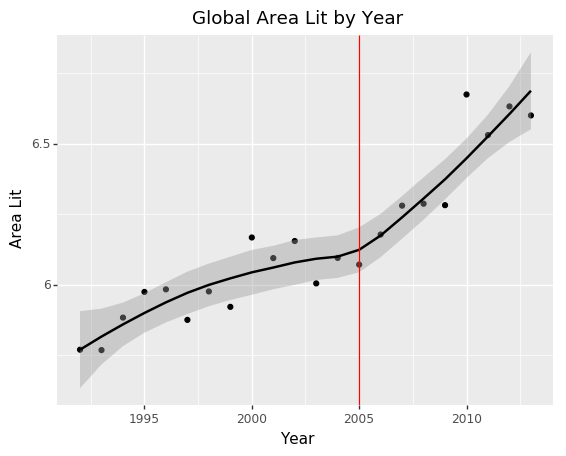

<ggplot: (7560054434)>

In [22]:
# Global trend - Area Lit
arealt = all_merged[['Year', 'Area Lit']].copy()
arealt_grouped = arealt.groupby(['Year']).mean().reset_index()
gg = p9.ggplot(arealt_grouped)
gg += p9.aes(x = 'Year', y = 'Area Lit' )
gg += p9.geom_point()
gg += p9.geom_smooth(method = 'loess')
gg += p9.geom_vline(xintercept=2005, color = 'red')
gg += p9.ggtitle('Global Area Lit by Year')
gg

Recall the faster changes in continents such as Africa, Middle East, and central Asia as reflected in the maps, I will draw separate time trends of night light measurement for each continent. 

The graph below confirms that for continents except North America and South Asia, Area Lit has been growing over time. For North America, Area Lit shrinks during 2000-2005, but returns to fast growth since 2005. For South Asia, Area Lit shrinks during 2003-2009, and returns to weak growth since then. Europe, Central Asia, Middle East, and Africa experienced the fastest growth, which is consistent with the observation of interactive maps over time. 

In [23]:
def fea_trend(f, c):
    '''Graph time trends for specified feature f for subgroup measure c'''
    c_sub = all_merged[['Year', c ,f]].copy()
    c_group = c_sub.groupby(['Year', f]).mean().reset_index()
    gg_c = p9.ggplot(c_group)
    gg_c += p9.aes(x = 'Year', y = c, color = f)
    gg_c += p9.geom_point(alpha = 0.5, size=0.5)
    gg_c += p9.geom_smooth(method = 'loess')
    gg_c += p9.ggtitle('{} of Each {} by Year'.format(c, f))
    gg_c += p9.ylab(c) 
    gg_c += p9.xlab('Year')    
    return(gg_c)

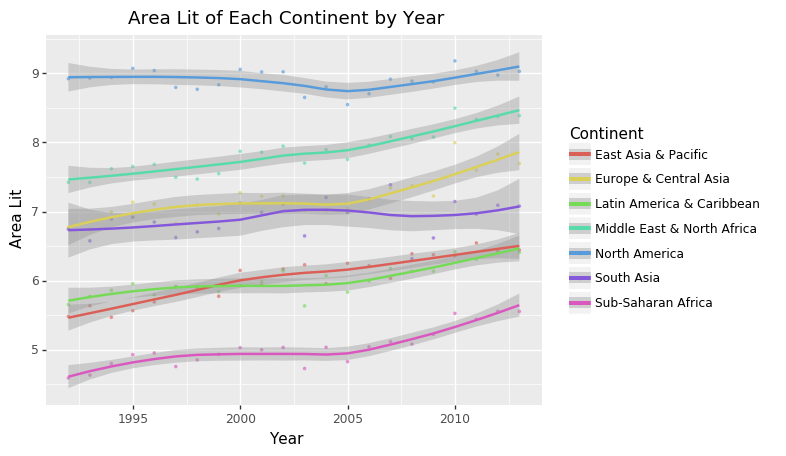

<ggplot: (-9223372029294745393)>

In [24]:
# Draw time trends for Area Lit by continent
fea_trend('Continent', 'Area Lit')

I am also interested in how GDP changes over time. Follwing the same method, I will first see the global time trend of GDP. There is also a cutting point that separate slow GDP growth from fast GDP growth, which is in year 2002 (marked with red vertical line). The abrupt changing point in GDP growth is actually 3 years earlier than that for night light growth, suggesting the lagging for night light measurement changes in response to GDP changes.

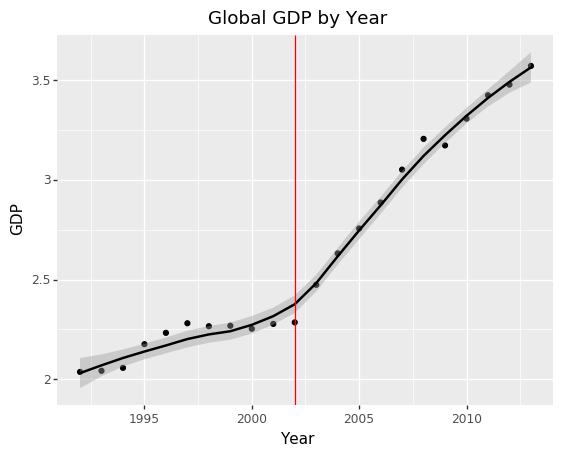

<ggplot: (7560034575)>

In [25]:
# Global trend - GDP
gdp = all_merged[['Year', 'GDP']].copy()
gdp_grouped = gdp.groupby(['Year']).mean().reset_index()
gg = p9.ggplot(gdp_grouped)
gg += p9.aes(x = 'Year', y = 'GDP' )
gg += p9.geom_point()
gg += p9.geom_smooth(method = 'loess')
gg += p9.geom_vline(xintercept=2002, color = 'red')
gg += p9.ggtitle('Global GDP by Year')
gg

The figure below further depicts how GDP in each continent changes over time. All continents except Europe and Central Asia experience an increase in GDP over time. This is contradictory to the results for night light measurement. For Europe and Central Asia, they do not show any decrease in night light, but experience decrease in GDP during 1992-2000. For North and America and South Asia, they experience roughly 5 years of decrease in night light, but have been constantly increasing in GDP over time. Another interesting observation is that Europe and Central Asia switch position with Middle East and North Africa in the GDP graph and night light graph, showing that Europe and Central Asia have relatively higher GDP level but lower night light level. 

These interesting patterns suggest that night light measurement might not approximate GDP so well as economists believe. 

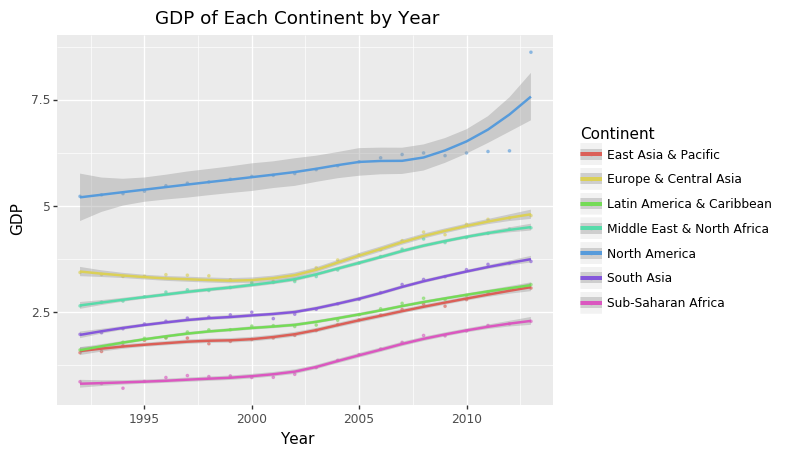

<ggplot: (7560056282)>

In [26]:
# Draw time trends for GDP by continent
fea_trend('Continent', 'GDP')

Graphing by continent certainly reveals some interesting patterns of changes in night light measures and economic status. Another aspect of economic status is country's income group.

Below I graph the time trend of night light measure by income group. In general, Area Lit is positively correlated with Income Group, since high income OECD countries have the highest Area Lit level over time, whereas low income countries have the lowest Area Lit level over time. However, high income nonOECD countries is an exception. Although these are high income countries, they have the second lowest Area Lit level over time. Better economic status not neccearily associates with higher night light levels. This interesting observation again suggests that night light measurement might not approximate GDP so well. 

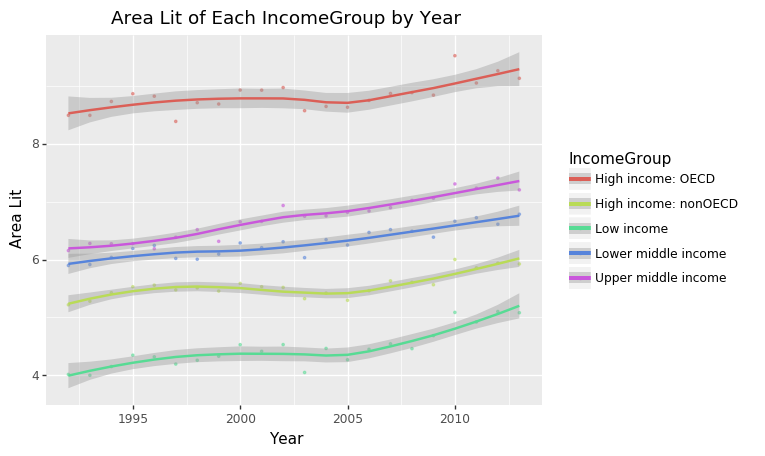

<ggplot: (7560141439)>

In [27]:
# Draw time trends for Area Lit by income group
fea_trend('IncomeGroup', 'Area Lit')

#### Is night light correlated with economic activities?
Through visualization in previous section, I find evidence suggesting that night light measurement might not be so ideal an proxy for GDP as economists believe. In this section, I will go one step further and study the correlation between night light measure and GDP. I also include two other variables, CO2 emissions and electricity consumption, which are popular proxies for GDP.

Note that to be consistent with the next section for random forest analysis, where early years have too many missing values in other variables, I will limit my analysis to years after 2000.

In the following part, I first draw the scatter matrix depicting the correlation between GDP and selected proxies at the global level. The diagnal entries are the histograms for each variable, and the off-diagnal entries show the scatter plot of each pair of variables, and the red numbers in upper right panel are the calculated correlation between each pair. The purpose of this project is to study the correlation between GDP and its proxies, so I only focus on the first row of matrix. All the proxies are highly correlated with GDP, with correlation value exceeding 0.9. Economists commonly use this as an argument that night light measure is a good proxy for economic activities. 

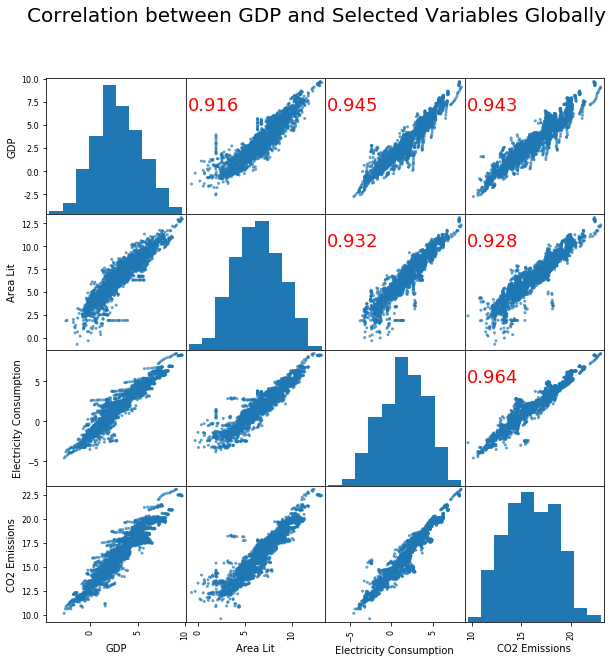

In [28]:
# Global: correlation between GDP and proxies
gl_merged=all_merged.copy().loc[all_merged['Year']>2000][['GDP','Area Lit', 
                                                          'Electricity Consumption',
                                                          'CO2 Emissions', 'Continent',
                                                          'IncomeGroup']]
axes = scatter_matrix(gl_merged, alpha = 0.7, figsize = (10, 10))
plt.suptitle(t = 'Correlation between GDP and Selected Variables Globally', 
             fontsize = 20 )
corr = gl_merged.corr().values
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.2, 0.8), size = 18, 
                        color = 'red', xycoords='axes fraction', ha='center', va='center')
plt.show()

Going one step further, I explore the correlation between GDP and its proxies for countries of different income groups. Selecting an income group in the dropdown window, we can see the correponding scatter matrix. It's shown from the matrices that night light measures have relatively lower correlation with GDP in low income countries and high income nonOECD countries, but the correlation is still higher than 0.75. This suggests that the correlation between economic activities and night light measures might actually have different patterns for countries of different levels of econoimc activities, but the correlation is pretty high in general. 

In [29]:
# Make a dropdown to select the Income Group
incg = widgets.Dropdown(
    options= list(all_merged[all_merged['IncomeGroup'].notnull()]['IncomeGroup'].unique()),
    value='Low income',
    description='IncGroup:',
)

def plotit(incg):
    '''Graph scatter matrix for selected income group'''
    all_submerged = all_merged.copy()[['GDP','Area Lit', 'Electricity Consumption',
                                       'CO2 Emissions', 'IncomeGroup', 'Year']]
    all_submerged = all_submerged.loc[(all_submerged['IncomeGroup'] == incg) 
                                      &(all_submerged['Year'] > 2000) ]
    all_submerged = all_submerged.drop(columns = 'Year')
    axes = scatter_matrix(all_submerged, alpha = 0.7, figsize = (10, 10))
    plt.suptitle(t = 'Correlation between GDP and Selected Variables in {}'.format(incg), 
                 fontsize = 20 )
    corr = all_submerged.corr().values
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.2, 0.8), color = 'red', 
                            xycoords='axes fraction', ha='center', va='center')
    plt.show()           

# Get interactive scatter matrix by selecting income group
interactive(plotit, incg=incg)

interactive(children=(Dropdown(description='IncGroup:', index=4, options=('High income: nonOECD', 'Upper middl…

If we do believe that the correlation between GDP and night light measure is high, then we should expect to observe high correlation between the growth of GDP and the growth of night light measure. Otherwise, the high correlation might only comes from spurious relationship. In time series analysis, for independent non-stationary variables, simply calculating the correlation between them will provide misleading statistical evidence of a strong linear relationship. Hence, to avoid this problem, it is necessary to check the correlation between the growth of variables of interest. 

In the following part, I first take the difference between current variable values and its value one year before, and then calculate the correlation between these differences.

In [30]:
# Generate data set for differenced variables
dat = all_merged.copy()
prop_na = all_merged.isna().mean()

# Keep rows with less NaN.
few_na_ind = prop_na.loc[prop_na < 0.25]
dat = dat[few_na_ind.index]
measurement_names = ['Area Lit', 'Electricity Consumption', 
          'CO2 Emissions', 'GDP', 'Population']
dat = dat[['Code', 'Year', 'Region', 'IncomeGroup', 'Continent'] + measurement_names]
dat = dat.sort_values(by = ['Code', 'Year'])
dat.head()


dat_lag = dat.copy()
for measurement in measurement_names:
    for lag in [1, 2]:
        lag_varname = measurement + '_lag_' + str(lag)
        dat_lag[lag_varname] = dat_lag.groupby('Code')[measurement].shift(lag)
    lag1_varname = measurement + '_lag_1'
    diff_varname = measurement + '_diff'
    dat_lag[diff_varname] = dat_lag[measurement] - dat_lag[lag1_varname]
        
dat_lag = dat_lag.loc[dat_lag['Year'] > 2000]

# save dat_lag to csv

dat_lag.to_csv('dat_lag.csv')

After taking difference over time, the previous strong correlation patterns are gone dramatically. The graph below shows that correlation between lagged difference in GDP and lagged difference in night light measure is pretty low (0.035), and much smaller than those for CO2 Emissions and electricity consumption. 

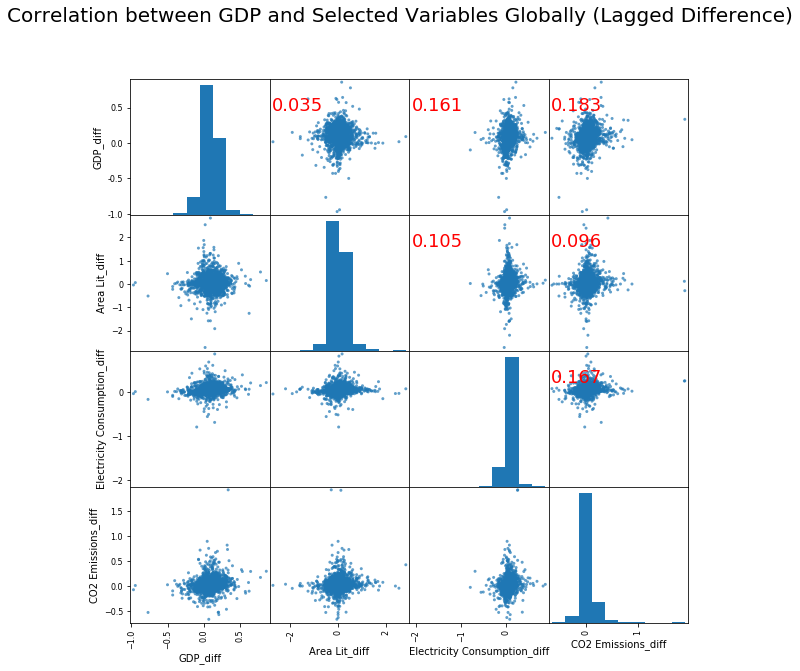

In [31]:
# Global: correlation between lagged difference of GDP and proxies
dat_sublag = dat_lag.copy()[['GDP_diff','Area Lit_diff', 'Electricity Consumption_diff',
                                 'CO2 Emissions_diff', 'IncomeGroup']]
axes = scatter_matrix(dat_sublag, alpha = 0.7, figsize = (10, 10))
plt.suptitle(t ='Correlation between GDP and Selected Variables Globally (Lagged Difference)',
             fontsize = 20 )
corr = dat_sublag.corr().values
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.2, 0.8), size = 18, color = 'red',
                        xycoords='axes fraction', ha='center', va='center')
plt.show()   

Below I repeat the same exercise for countries of different income groups. Selecting an income group in the dropdown window, I find that in general night light measures have low correlation with GDP compared to the other two proxies. Low income countries actually have the highest positive correlation between GDP and night light measures. For high income OECD countries, the correlation between GDP and night light measure is even negative.

In [32]:
def d_inc(incg):
    '''Graph scatter matrix for selected income group using differenced variables'''
    dat_sublag = dat_lag.copy()[['GDP_diff','Area Lit_diff', 'Electricity Consumption_diff',
                                 'CO2 Emissions_diff', 'IncomeGroup']]    
    dat_sublag = dat_sublag.loc[dat_sublag['IncomeGroup'] == incg]
    axes = scatter_matrix(dat_sublag, alpha = 0.7, figsize = (10, 10))
    plt.suptitle(t = 'Correlation between Lag 1 GDP and Selected Variables in {}'.format(incg), fontsize = 20 )
    corr = dat_sublag.corr().values
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.2, 0.8), color = 'red', xycoords='axes fraction', ha='center', va='center')
    plt.show()  
    
# Get interactive scatter matrix by selecting income group
interactive(d_inc, incg = incg)

interactive(children=(Dropdown(description='IncGroup:', index=4, options=('High income: nonOECD', 'Upper middl…

#### Is night light predictive of economic activities?

In the previous section I show that the marginal correlation between night light measurement and GDP is low within each income group after adjusting for spurious correlation using the lagged difference. This is not surprising in macro-economics because the non-spurious association between variables is usually small. Since the mechanism that determines the dynamics of macro-economics is extremely delicate, one might use other measures to assess whether night light is associated with economic activities instead of merely relying on the marginal correlation. In particular, I use the predictive power in this section. If night light measure is an "important" variable that is significantly conductive to predicting economic activities, then it is worth being considered in future research.

###### Methodology
My approach is based on a general strategy proposed by Leo Breiman in the paper $\scriptsize \textit{Random Forests}$ in 2011, which is to construct an appropriate variable importance measure. Specifically, given an outcome $Y$, a set of predictors $X \triangleq (X_1, \ldots, X_K)$, and a machine learning algorithm $\mathcal{A}$ to predict $Y$ using $X$, one starts by measuring the predictive accuracy using $\mathcal{A}$ on the original dataset. Denote this accuracy by $S_{\mathrm{orig}}$. Then for each covariate $X_{k}$, one applies $\mathcal{A}$ on an artificial dataset with $X_{k}$ randomly permuted while all other variables remains the same. Intuitively, the permutation makes $X_{k}$ "uselesss", and if $X_{k}$ is actually helpful in predicting $Y$, then the predictive accuracy will significantly decrease. As a consequence, the gap of predictive accuracy between the original dataset and the permuted dataset characterizes the importance of $X_{k}$. To account for the randomness in permutation, one repeats the above permutation for 100 times for each variable, and obtain the predictive accuracy as $S_{k}^{(1)}, ... , S_{k}^{(100)}$. Then the variance importance score for variable $X_{k}$ is computed as
$$\mathrm{V}_{k} = \frac{1}{100}\sum_{j=1}^{100}(S_{\mathrm{orig}} - S_{k}^{(j)}).$$
$V_{k}$ measures the loss of predictive accuracy after turning $X_{k}$ into pure noise. 

In this section, I use the random forests (RF) as the learning algorithm $\mathcal{A}$ for three reasons: (1) RF generally has desirable predictive power; (2) unlike deep neural networks, RF does not require a large sample size; (3) the predictive accuracy of RF can be accessed by using Out-Of-Bag (OOB) samples without the need to construct a separate testing set. The details of OOB samples can be found in Chapter 15.3.1 of the book $\scriptsize \textit{The Elements of 
Statistical Learning: Data Mining, Inference, and Prediction}$ by Hastie et al. (2017) and here I sketch the basics for clarification. An RF learner is an ensemble of decision trees that is built on a bootstrap sample with sample size $n$. Because bootstrapping is sampling without replacement, there are $(1 - 1/n)^{n}\approx e^{-1} \approx 36.8\%$ fraction of observations not included in the training set on average for each tree. The excluded samples for each tree constitute the OOB samples for that tree. OOB samples can be taken as testing samples since they are not involved in the training procedure. Unlike other methods that rely on a separate testing set, every observation serves as a testing point in the trees for which it is OOB. To assess the predictive accuracy, a predicted value $\hat{y}_{i}$ is computed for observation $i$ as follows:
$$\hat{y}_{i} = \frac{\sum_{b = 1}^{B}\hat{y}_{ib}I(i\mbox{ is OOB for tree }b)}{\sum_{b = 1}^{B}I(i\mbox{ is OOB for tree }b)}$$
where $B$ is the total number of trees, $\hat{y}_{ib}$ is the predicted value by passing observation $i$ into $b$-th tree. Note that the construction of $\hat{y}_{i}$ only involves the trees for which observation $i$ is OOB and thus avoids overfitting. Finally, one calculate the correlation between $(\hat{y}_{1}, ... , \hat{y}_{n})$ and $(y_{1}, ..., y_{n})$ to measure the predictive accuracy. This is implemented as default in the $\scriptsize \textit{RandomForestRegressor}$ in $\scriptsize \textit{sklearn}$ package. 

The following part implements the functions for variable importance using RF with the OOB score as the measure of predictive accuracy.

In [33]:
from sklearn.ensemble import RandomForestRegressor

def RF_oob(X, y):
    '''Wrapper to get OOB score from an RF regressor'''
    model = RandomForestRegressor(n_estimators=100, min_samples_leaf=8, random_state=20181125, oob_score=True)
    model.fit(X, y)
    return(model.oob_score_)

def RF_permute_oob(X, y, j, nreps = 50):
    '''Get OOB scores for each of nreps permutation of the j-th variable'''
    scores = np.empty(nreps)
    for i in range(nreps):
        permute_X = np.array(X)
        permute_X[:, j] = np.random.permutation(permute_X[:, j])
        scores[i] = RF_oob(permute_X, y)
    return(scores)

def RF_permute_varimp(X, y, nreps = 50):
    '''Get variable importance for each variable
    
       Output: 
       A dataframe with three columns: variable names, variable importance scores, 
       and p-values that give statistical significance of the variable importance.
    '''
    orig_oob = RF_oob(X, y)
    p = X.shape[1]
    permute_oob = np.empty((p, nreps))
    for j in range(p):
        permute_oob[j, :] = RF_permute_oob(X, y, j, nreps)
        print('{}-th variable done!'.format(j+1))
    mean_oob = [np.mean(x) for x in permute_oob]
    mean_decrease_imp = orig_oob - mean_oob
    pvals_oob = [np.mean(x > orig_oob) for x in permute_oob]
    res = pd.DataFrame({'imp': mean_decrease_imp, 'pvals': pvals_oob})
    return(res)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



###### Other Variables
I use the world bank API to scrape 46 indicators that affect the economic activities but are not directly involved in the calculation of GDP, implementing with the $\scriptsize \textit{wbdata}$ package. These variables cover agriculture, energy, environment, health care, education, and employment, and they are selected to have reasonable coverage in terms of the number of available years and available countries. I put the variables and their ID in World Bank database in a csv file and the following part shows the list. 

In [34]:
useful_inds_list = pd.read_csv('wb_selected_indicators.csv')
useful_inds_list.head()

,IndicatorCode,IndicatorName,ShortName
0,AG.AGR.TRAC.NO,"Agricultural machinery, tractors",Agricultural machinery
1,AG.CON.FERT.ZS,Fertilizer consumption (kilograms per hectare ...,Fertilizer consumption
2,AG.LND.AGRI.K2,Agricultural land (sq. km),Agricultural land area
3,AG.LND.FRST.K2,Forest area (sq. km),Forest area
4,AG.LND.TOTL.K2,Land area (sq. km),Land area


Then I scrape the data from the World Bank. The three lines are commented out because it takes around 45 minutes with stable internet connection. The final dataset is stored in extdata.csv for later use.

In [35]:
import wbdata
indicators = {}
for i in range(useful_inds_list.shape[0]):
    indname = useful_inds_list['IndicatorCode'][i]
    indicators[indname] = useful_inds_list['ShortName'][i]

# extdata = wbdata.get_dataframe(indicators).reset_index()
# extdata['Year'] = pd.to_numeric(extdata['date'])
# extdata.to_csv('extdata.csv')

extdata = pd.read_csv('extdata.csv', index_col=0)
extdata.head()

,country,date,Agricultural machinery,Fertilizer consumption,Agricultural land area,Forest area,Land area,Crop production index,Food production index,Livestock production index,...,Employment in industry,Labor force participation rate for youth,Refugee population (asylum),Refugee population (origin),Adolescent fertility rate,Birth rate,Death rate,Life expectancy,Intentional homicides,Year
0,Afghanistan,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,145.245,51.293,32.396,32.292,NaN,1960
1,Afghanistan,1961,120.0,NaN,377000.0,NaN,652860.0,65.69,53.21,43.37,...,NaN,NaN,NaN,NaN,145.245,51.395,31.898,32.742,NaN,1961
2,Afghanistan,1962,150.0,NaN,377600.0,NaN,652860.0,67.18,53.86,43.99,...,NaN,NaN,NaN,NaN,145.245,51.488,31.414,33.185,NaN,1962
3,Afghanistan,1963,200.0,NaN,378100.0,NaN,652860.0,65.58,53.83,47.03,...,NaN,NaN,NaN,NaN,145.245,51.572,30.938,33.624,NaN,1963
4,Afghanistan,1964,200.0,NaN,378730.0,NaN,652860.0,71.31,58.23,48.56,...,NaN,NaN,NaN,NaN,145.245,51.644,30.467,34.060,NaN,1964


###### Data processing

My ultimate goal is to predict the growth (lagged difference) of GDP using the growth (lagged difference) of other variables, including night light. Since the variables are all time series, it is useful to also include variables in previous periods. In other words, instead of simply using $\Delta X_{t} = (\Delta X_{1t}, ..., \Delta X_{Kt})$ to predict $\Delta y_{t}$, we also include $\Delta X_{t-1}, \Delta X_{t - 2}, ..., \Delta X_{t - m}$ and $\Delta y_{t-1}, \Delta y_{t - 2}, ... , \Delta y_{t - m}$ as the predictors. In this project, I set $m = 3$. 

In order to clean the data as desired, I need to do the following tasks: (1) merging my previous data set with the variables obtained from World Bank database; (2) removing all missing values, because $\scriptsize \textit{RandomForestRegressor}$ cannot handle missing values automatically; (3) generating lagged difference of each variable.

The analysis in this section is quite different from those in previous sections, so I re-process the data for clarity.

In [36]:
# Read the dataset
data = pd.read_excel('nightlight.xlsx')
data.columns = ['Code','Region','Year','Area Lit','Electricity Consumption','CO2 Emissions',
 'GDP','Population','N2O Emissions','CH4 Emissions','Fluoride Emissions','Poverty Headcount Ratio']
data = data.sort_values(by = ['Code', 'Year'])

In [37]:
# Get extra country information from world bank
country_info = wbdata.get_country(display=False)
country_info = pd.DataFrame(country_info)
useful_columns = ['id', 'incomeLevel', 'latitude', 'longitude', 'name', 'region']
country_info = country_info[useful_columns]
country_info[['incomeLevel', 'region']] = country_info[['incomeLevel', 'region']].applymap(lambda x: x['value'])
country_info = country_info.query('incomeLevel not in "Aggregates"')
country_info.columns = ['Code', 'IncomeLevel', 'Latitude', 'Longitude', 'Country', 'Region']

In [38]:
# Use Country.csv to get IncomeGroup
country_info2 = pd.read_csv('Country.csv')
country_info = country_info.merge(country_info2[['CountryCode', 'IncomeGroup']], how='left', 
                                  left_on='Code', right_on='CountryCode')
country_info = country_info.drop(['CountryCode', 'IncomeLevel'], axis = 1)
country_info.head()

,Code,Latitude,Longitude,Country,Region,IncomeGroup
0,ABW,12.5167,-70.0167,Aruba,Latin America & Caribbean,High income: nonOECD
1,AFG,34.5228,69.1761,Afghanistan,South Asia,Low income
2,AGO,-8.81155,13.242,Angola,Sub-Saharan Africa,Upper middle income
3,ALB,41.3317,19.8172,Albania,Europe & Central Asia,Upper middle income
4,AND,42.5075,1.5218,Andorra,Europe & Central Asia,NaN


In [39]:
# Add the country information into the dataset obtained from World Bank
extdata = extdata.merge(country_info, left_on='country', right_on='Country')
extdata = extdata.drop(['country', 'Country', 'date'], axis = 1)
extdata.head()

,Agricultural machinery,Fertilizer consumption,Agricultural land area,Forest area,Land area,Crop production index,Food production index,Livestock production index,Surface area,Energy intensity level,...,Birth rate,Death rate,Life expectancy,Intentional homicides,Year,Code,Latitude,Longitude,Region,IncomeGroup
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.293,32.396,32.292,NaN,1960,AFG,34.5228,69.1761,South Asia,Low income
1,120.0,NaN,377000.0,NaN,652860.0,65.69,53.21,43.37,652860.0,NaN,...,51.395,31.898,32.742,NaN,1961,AFG,34.5228,69.1761,South Asia,Low income
2,150.0,NaN,377600.0,NaN,652860.0,67.18,53.86,43.99,652860.0,NaN,...,51.488,31.414,33.185,NaN,1962,AFG,34.5228,69.1761,South Asia,Low income
3,200.0,NaN,378100.0,NaN,652860.0,65.58,53.83,47.03,652860.0,NaN,...,51.572,30.938,33.624,NaN,1963,AFG,34.5228,69.1761,South Asia,Low income
4,200.0,NaN,378730.0,NaN,652860.0,71.31,58.23,48.56,652860.0,NaN,...,51.644,30.467,34.060,NaN,1964,AFG,34.5228,69.1761,South Asia,Low income


In [40]:
def describe_data(data):
    '''
    A wrapper to report the number of countries and the number of variables
    '''
    ncountries = len(data['Code'].unique())
    nvars = data.shape[1] - 4
    print('data has {} countries and {} variables'.format(ncountries, nvars))

In [41]:
# Merge the previous dataset and the dataset obtained from World Bank.
data_all = pd.merge(data.drop('Region', axis=1), extdata, 
                    on=['Code', 'Year']).query('Year > 1995 and Year < 2014')
describe_data(data_all)

data has 212 countries and 55 variables


The next step is to remove the missing values. I first remove the variables with more than 15% of missing values and then remove the observations with missing values in the remaining variables. We are left with 131 countrie and 26 variables (not including the variables for country information).

In [42]:
var_missing_df = data_all.isna().mean()
nomissing_vars = var_missing_df.index.values[var_missing_df.values < 0.15]
data_all = data_all[nomissing_vars]
describe_data(data_all)

data has 212 countries and 26 variables


In [43]:
country_missing_df = data_all.groupby('Code').aggregate(lambda x: x.isna().mean()).apply(max, axis = 1)
nomissing_countries = country_missing_df.index.values[country_missing_df.values == 0]
data_all = data_all.query('Code in @nomissing_countries')
describe_data(data_all)

data has 131 countries and 26 variables


The next step is to generate lagged difference of each variable up to order 3 (eg. $X_{t-3} - X_{t - 4}$).

In [44]:
varnames = [x for x in data_all.columns.values if x not in 
            ['Code', 'Year', 'Region', 'IncomeGroup', 'Latitude', 'Longitude']]
data_all_lag = data_all.copy()
nlags = 4
for var in varnames:
    for lag in (np.arange(nlags) + 1):
        lag_varname = var + '_lag_' + str(lag)
        data_all_lag[lag_varname] = data_all_lag.groupby('Code')[var].shift(lag)
    data_all_lag[var + '_diff'] = data_all_lag[var] - data_all_lag[var + '_lag_1']
    for j in (np.arange(nlags - 1) + 1):
        data_all_lag[var + '_diff_' + str(j + 1)] = data_all_lag[var + '_lag_' + str(j)] - data_all_lag[var + '_lag_' + str(j + 1)]

data_all_lag = data_all_lag.query('Year > 2000')
data_all_lag.to_csv('data_lag.csv')
data_all_lag.head()

,Code,Year,Area Lit,Electricity Consumption,CO2 Emissions,GDP,Population,Agricultural land area,Forest area,Land area,...,Death rate_diff_3,Death rate_diff_4,Life expectancy_lag_1,Life expectancy_lag_2,Life expectancy_lag_3,Life expectancy_lag_4,Life expectancy_diff,Life expectancy_diff_2,Life expectancy_diff_3,Life expectancy_diff_4
53,AGO,2001,6.010137,0.302132,16.090952,2.190097,16.560393,573000.0,596032.0,1246700.0,...,-0.755,-0.696,47.113,46.105,45.192,44.385,1.087,1.008,0.913,0.807
54,AGO,2002,5.952767,0.377532,16.354417,2.525516,16.594932,573900.0,594784.0,1246700.0,...,-0.800,-0.755,48.200,47.113,46.105,45.192,1.141,1.087,1.008,0.913
55,AGO,2003,5.752012,0.500630,16.019912,2.652463,16.630404,575900.0,593536.0,1246700.0,...,-0.829,-0.800,49.341,48.200,47.113,46.105,1.167,1.141,1.087,1.008
56,AGO,2004,6.201189,0.467551,16.749015,2.977612,16.665957,575900.0,592288.0,1246700.0,...,-0.840,-0.829,50.508,49.341,48.200,47.113,1.168,1.167,1.141,1.087
57,AGO,2005,6.101788,0.726572,16.768148,3.340516,16.701034,575900.0,591040.0,1246700.0,...,-0.832,-0.840,51.676,50.508,49.341,48.200,1.157,1.168,1.167,1.141


###### Computing Variable Importance

Finally I compute the variable importance using RF. I first transform the outcome and the predictors into Numpy arrays and then pass them into the function $\scriptsize \textit{RF_permute_varimp}$ defined at the beginning of this section. The code will run roughly 9 hours using the global dataset so I commented it out and save the results into global_imp.csv. I also perform the analysis on each income group. Each of them will run approximately 1 hour and the results are saved in XXX_imp.csv where XXX represents a specific income group.

In [45]:
varnames = [x for x in data_all_lag.columns.values if "diff" in x or x in ['Latitude', 
                                                                           'Longitude']]
data_tmp = data_all_lag[varnames]
y = data_tmp['GDP_diff'].values
X_df = data_tmp.drop('GDP_diff', axis = 1)
varnames = X_df.columns
X = X_df.values

In [46]:
## Variable importance using the global data
# global_imp = RF_permute_varimp(X, y, nreps=50)
# global_imp['var'] = varnames
# global_imp.to_csv('global_imp.csv')

In [47]:
# Create a dictionary for the subgroup and the csv filename to store the variable importance
incomegroup_csv = {'High income: OECD': 'high_OECD_imp.csv',
                   'High income: nonOECD': 'high_nonOECD_imp.csv',
                   'Upper middle income': 'upper_middle_imp.csv',
                   'Lower middle income': 'lower_middle_imp.csv',
                   'Low income': 'low_imp.csv'}

In [48]:
# Variable importance using the data from each income group
varnames = [x for x in data_all_lag.columns.values if "diff" in x or x in ['Latitude', 
                                                                           'Longitude', 
                                                                           'IncomeGroup']]
data_all_diff = data_all_lag[varnames]
for subgroup in incomegroup_csv.keys():
    data_tmp = data_all_diff.query('IncomeGroup == @subgroup').drop('IncomeGroup', axis = 1)
    y = data_tmp['GDP_diff'].values
    X_df = data_tmp.drop('GDP_diff', axis = 1)
    varnames = X_df.columns
    X = X_df.values
#     imp = RF_permute_varimp(X, y, nreps=50)
#     imp['var'] = varnames
#     filename = incomegroup_csv[subgroup]
#     imp.to_csv(filename)

###### Visualizing variable importance
In this part, I visualize the variable importance using the csv files generated above. Note that I multiply the calculated variable by 100 for better visualization.

At the global level, Area Lit of different lags are among the Top 4 most important variables for predicting GDP. Looking at the specific pattern for each income group, I find that Area Lit and its lagged terms are generally quite important compared to other variables, but high income nonOECD countries are an exception. For high income nonOECD countries, night light measure does not perform significantly better than other proxies. 


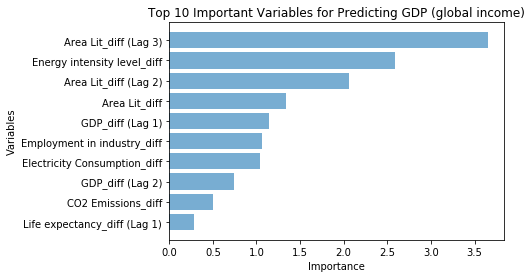

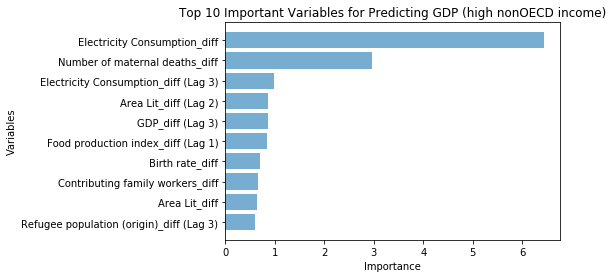

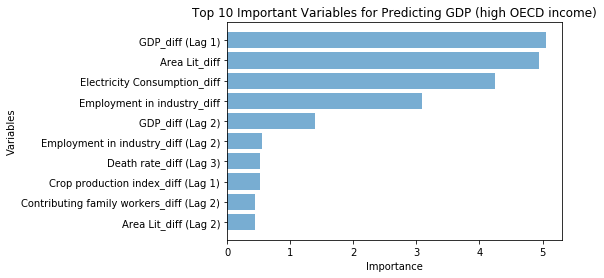

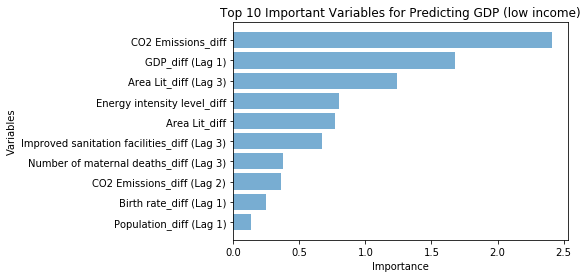

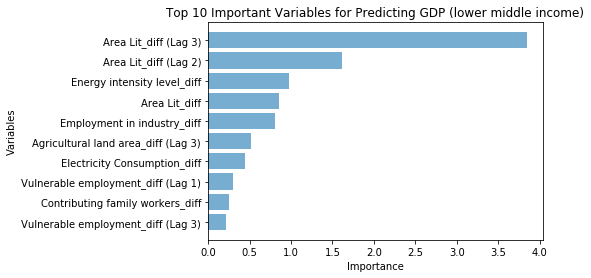

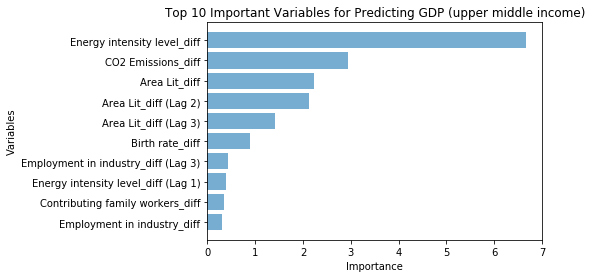

In [49]:
for file in ['global_imp.csv', 'high_nonOECD_imp.csv', 'high_OECD_imp.csv', 
             'low_imp.csv', 'lower_middle_imp.csv', 'upper_middle_imp.csv']:
    imp = pd.read_csv(file)
    imp_descend = imp.copy().sort_values(by = ['imp'], ascending = False)
    imp_descend['imp'] = imp_descend['imp'] * 100
    imp_descend_10 =imp_descend.copy().head(10)
    imp_descend_10['var'] = imp_descend_10['var'].str.replace('_2', ' (Lag 1)')
    imp_descend_10['var'] = imp_descend_10['var'].str.replace('_3', ' (Lag 2)')
    imp_descend_10['var'] = imp_descend_10['var'].str.replace('_4', ' (Lag 3)')

    incgroup = file.replace('_imp.csv', ' income')
    incgroup = incgroup.replace('_', ' ')
    plt.barh(imp_descend_10['var'], imp_descend_10['imp'], 
         align = 'center', alpha = 0.6)
    plt.yticks()
    
    plt.title('Top 10 Important Variables for Predicting GDP ({})'.format(incgroup))
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.gca().invert_yaxis()
    plt.show()

#### Summary

Night light is considered as a good proxy for economic activities in literature. However, in this project, I found that this conclusion is generally based on spurious correlation. After correcting for this, the marginal correlation between night light measurement and economic activities is much lower than concluded in economic literature. Thus, night light is not a good proxy for economic activities. 

But, this does not rule out the possibility that night light measurement is a good predictor of economic activities. In my predictive analysis, I find that night light is still among the best predictors of economic activities. The importance of night light differs across income groups, which is worthy of further exploring. 

In summary, I find that night light is not a good proxy, but a good predictor of economic activities. 
